# Setup

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
!pip install surprise

In [32]:
import os
import json
import numpy as np
import pandas as pd
import time
from surprise import Dataset
from surprise import Reader
from surprise import dump
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.model_selection import GridSearchCV
from tqdm import tqdm

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt
from functools import reduce

In [33]:
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Data Processing



In [34]:
business_path = "/content/drive/MyDrive/SML IW/yelp_academic_dataset_business.json"

business_ids, names, addresses, cities, states, latitudes, longitudes, stars, review_counts, is_open, categories = [], [], [], [], [], [], [], [], [], [], []
with open(business_path) as f:
    for i, line in enumerate(f):
        blob = json.loads(line)
        all_categories = blob["categories"]
        if all_categories != None:
          if "Restaurants" in all_categories or "Food" in all_categories:
            if blob["review_count"] > 30:          
              business_ids += [blob["business_id"]]
              names += [blob["name"]]
              addresses += [blob["address"]]
              cities += [blob["city"]]
              states += [blob["state"]]
              latitudes += [blob["latitude"]]
              longitudes += [blob["longitude"]]
              stars += [blob["stars"]]
              review_counts += [blob["review_count"]]
              is_open += [blob["is_open"]]
              categories += [blob["categories"]]
        
business_ = pd.DataFrame(
    {"business_id": business_ids, 
     "business_name": names,
     "business_address": addresses,
     "business_city": cities, 
     "business_state": states, 
     "business_latitude": latitudes, 
     "business_longitude": longitudes, 
     "stars": stars, 
     "review_counts": review_counts, 
     "is_open": is_open,
     "categories": categories}
)

business_.head()


,business_id,business_name,business_address,business_city,business_state,business_latitude,business_longitude,stars,review_counts,is_open,categories
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,39.955505,-75.155564,4.0,80,1,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
1,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,27.916116,-82.760461,4.5,100,0,"Food, Delis, Italian, Bakeries, Restaurants"
2,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,39.953949,-75.143226,4.0,245,1,"Sushi Bars, Restaurants, Japanese"
3,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,39.943223,-75.162568,4.5,205,1,"Korean, Restaurants"
4,WKMJwqnfZKsAae75RMP6jA,Roast Coffeehouse and Wine Bar,10359 104 Street NW,Edmonton,AB,53.546045,-113.499169,4.0,40,0,"Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re..."


In [36]:
# LOAD USER DATA

user_path = "/content/drive/MyDrive/SML IW/yelp_academic_dataset_user.json"

# stop = 5000000

users, names, review_counts, since, friends, useful, \
            funny, cool, n_fans, years_elite, average_stars = [], [], [], [], [], [], [], [], [], [], []
with open(user_path) as f:
    for i, line in enumerate(f):
        # if i == stop:
        #   break
        blob = json.loads(line)
        if blob["review_count"] > 20:
          users += [blob["user_id"]]
          names += [blob["name"]]
          review_counts += [blob["review_count"]]
          since += [blob["yelping_since"]]
          friends += [blob["friends"]]
          useful += [blob["useful"]]
          funny += [blob["funny"]]
          cool += [blob["cool"]]
          n_fans += [blob["fans"]]
          years_elite += [blob["elite"]]
          average_stars += [blob["average_stars"]]
        
users_ = pd.DataFrame(
    {"user_id": users, 
     "user_name": names,
     "user_review_count": review_counts,
     "user_yelp_since": since,
     "friends": friends,
     "useful_reviews": useful,
     "funny_reviews": funny,
     "cool_reviews": cool,
     "n_fans": n_fans,
     "years_elite": years_elite,
     "average_stars": average_stars
    }
)

users_.head()

,user_id,user_name,user_review_count,user_yelp_since,friends,useful_reviews,funny_reviews,cool_reviews,n_fans,years_elite,average_stars
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",7217,1259,5994,267,2007,3.91
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,"ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",43091,13066,27281,3138,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...",3.74
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,"LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",2086,1010,1003,52,"2009,2010,2011,2012,2013",3.32
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,"enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",512,330,299,28,"2009,2010,2011",4.27
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",29,15,7,1,,3.54


In [37]:
reviews_path = "/content/drive/MyDrive/SML IW/yelp_academic_dataset_review.json"
sentiment = SentimentIntensityAnalyzer()

stop = 4000000

user_ids, business_ids, stars, dates, texts = [], [], [], [], []
with open(reviews_path) as f:
    for i, line in enumerate(f):
        if i == stop:
          break
        blob = json.loads(line)
        user_ids += [blob["user_id"]]
        business_ids += [blob["business_id"]]
        stars += [blob["stars"]]
        dates += [blob["date"]]
        texts += [blob["text"]]
ratings_ = pd.DataFrame(
    {"user_id": user_ids, "business_id": business_ids, "rating": stars, "date": dates, "text": texts}
)
user_counts = ratings_["user_id"].value_counts()
active_users = user_counts.loc[user_counts >= 5].index.tolist()
ratings_ = ratings_.loc[ratings_.user_id.isin(active_users)]
ratings_.head()

,user_id,business_id,rating,date,text
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,2018-07-07 22:09:11,"If you decide to eat here, just be aware it is..."
1,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,2012-01-03 15:28:18,I've taken a lot of spin classes over the year...
2,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,2014-02-05 20:30:30,Family diner. Had the buffet. Eclectic assortm...
4,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,2017-01-14 20:54:15,Cute interior and owner (?) gave us tour of up...
10,1WHRWwQmZOZDAhp2Qyny4g,uMvVYRgGNXf5boolA9HXTw,5.0,2015-06-21 14:48:06,My experience with Shalimar was nothing but wo...


# Baseline


In [164]:
baseline_df = ratings_.copy()
print(baseline_df.shape)
preds = business_[['business_id', 'stars']]
merged = reduce(lambda x,y: pd.merge(x,y, on='business_id'), [baseline_df, preds])
merged

(2148040, 5)


,user_id,business_id,rating,date,text,stars
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,2018-07-07 22:09:11,"If you decide to eat here, just be aware it is...",3.0
1,Iaee7y6zdSB3B-kRCo4z1w,XQfwVwDr-v0ZS3_CbbE5Xw,2.0,2017-05-13 17:06:55,This is the second time we tried turning point...,3.0
2,ejFxLGqQcWNLdNByJlIhnQ,XQfwVwDr-v0ZS3_CbbE5Xw,4.0,2017-08-08 00:58:18,The place is cute and the staff was very frien...,3.0
3,f7xa0p_1V9lx53iIGN5Sug,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,2017-11-19 02:20:23,We came on a Saturday morning after waiting a ...,3.0
4,gy7Ss1uTpCjbbGsghTvNsw,XQfwVwDr-v0ZS3_CbbE5Xw,2.0,2017-07-29 17:12:27,When I was shown to my seat of was still wet s...,3.0
...,...,...,...,...,...,...
1496748,D3b7NcRR6Pm_1Wwv9pa5iA,0f0oRQdl5qg3GqnXaifqww,5.0,2020-12-21 00:24:17,Absolutely amazing spicy pasta with fish. Had ...,4.0
1496749,mYL5kFw50PFV3rAIZiJx7A,IlV0z5N0B0eqTNQ5SkBN-A,4.0,2021-04-06 11:04:54,"Food was amazing. Had the pork chops, wedge an...",3.5
1496750,1T77bunKDVaLN6MvaouMMg,PZJqMdFa2zn51Td_jHOsMw,5.0,2020-07-26 00:42:51,Went there last night with my husband. For jus...,4.5
1496751,jrUuwjBT0vcDYnxtxPHi6A,8u70WVawnsReBWNv7IXNSg,5.0,2021-04-17 16:37:58,Hands down best blueberry boba tea I've ever h...,4.5


In [40]:
print("mae: ", mean_absolute_error(merged["rating"], merged["stars"]))
print("mse: ", mean_squared_error(merged["rating"], merged["stars"]))
print("r^2", r2_score(merged["rating"], merged["stars"]))

test_ranks = pd.Series(merged["rating"]).rank()
pred_ranks = pd.Series(merged["stars"]).rank()
stats.spearmanr(test_ranks, pred_ranks)

mae:  0.8984341437765616
mse:  1.3138644118301417
r^2 0.13605237542434967


SpearmanrResult(correlation=0.35955178473200905, pvalue=0.0)

# Naive Bayes

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import preprocessing

In [42]:
baseline_df = ratings_.copy()

In [43]:
# separating our features and target
X = baseline_df['text']
y = baseline_df['rating']

In [44]:
import string 

# function to remove only punctuations from the review text
def text_process(text):

    '''
    Takes in a string of text, then performs the following:
    1. Removes all punctuation
    2. Return the text as a list of words
    '''

    nopunc = [char for char in text if char not in string.punctuation]

    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split()]

In [45]:
print(X)

0          If you decide to eat here, just be aware it is...
1          I've taken a lot of spin classes over the year...
2          Family diner. Had the buffet. Eclectic assortm...
4          Cute interior and owner (?) gave us tour of up...
10         My experience with Shalimar was nothing but wo...
                                 ...                        
3999987    Closest Honey Green Tea to California chains t...
3999988    I would rather pay for service here than to ta...
3999989    I have had such a difficult time finding good ...
3999995    Hot Damn! Authentic and fresh, these dishes we...
3999996    Love, love, love \n\nTaco trio OMG. The roaste...
Name: text, Length: 2148040, dtype: object


In [46]:
# creating a bag of words which consist of entire text without punctuations and fiting it
bow_transformer = CountVectorizer().fit(X)

In [47]:
len(bow_transformer.vocabulary_)

332938

In [48]:
# Transform our review text
X = bow_transformer.transform(X)

In [49]:
print('Shape of Sparse Matrix: ', X.shape)

# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (2148040, 332938)
Density: 0.022309658683514696


In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (1503628, 332938)
Number transactions y_train dataset:  (1503628,)
Number transactions X_test dataset:  (644412, 332938)
Number transactions y_test dataset:  (644412,)


In [51]:
# Let us now train the model using Multinomial Naive Bayes Algorithm
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [52]:
print(X_test.shape)
print(y_test)

(644412, 332938)
798345     1.0
1173367    5.0
3676813    1.0
3351626    1.0
1440090    4.0
          ... 
98502      5.0
853970     4.0
3740365    5.0
1734272    3.0
2651609    2.0
Name: rating, Length: 644412, dtype: float64


In [53]:
# Let us now predict on the test set
nb_preds = nb.predict(X_test)

In [54]:
print("mae: ", mean_absolute_error(y_test, nb_preds))
print("mse: ", mean_squared_error(y_test, nb_preds))
print("r^2: ", r2_score(y_test, nb_preds))

mae:  0.5767304147036368
mse:  1.0681210157476895
r^2:  0.3809602135645621


In [55]:
test_ranks = pd.Series(y_test).rank()
nb_pred_ranks = pd.Series(nb_preds).rank()

In [56]:
stats.spearmanr(nb_pred_ranks, test_ranks)

SpearmanrResult(correlation=0.6767029624249535, pvalue=0.0)

# SVD


https://colab.research.google.com/drive/10A46EmY3jAZ8xB7PE9MjePwAgYD6Mej-?authuser=1#scrollTo=-7lHjyW9hOVr 

OR 

https://github.com/jiangzl2016/yelp-rating-prediction/blob/master/1_baseline_and_collaborative_filtering.ipynb

In [57]:
# Sample by users
user_id_unique = ratings_.user_id.unique()
user_id_sample = pd.DataFrame(user_id_unique, columns=['unique_user_id']).sample(frac= 0.8, replace=False, random_state=1)

ratings_sample = ratings_.merge(user_id_sample, left_on='user_id', right_on='unique_user_id') \
                    .drop(['unique_user_id'], axis=1)
print(ratings_sample)
print(ratings_sample.shape)
print(ratings_.shape)

                        user_id             business_id  rating  \
0        OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ     5.0   
1        OyoGAe7OKpv6SyGZT5g77Q  qjGS_7iaQDpbVhS6W8qkHQ     5.0   
2        OyoGAe7OKpv6SyGZT5g77Q  tkFXSTpI-JmDgzhPU8ZsVA     5.0   
3        OyoGAe7OKpv6SyGZT5g77Q  CHrAJdhMg4ruIg8zVF-vog     5.0   
4        OyoGAe7OKpv6SyGZT5g77Q  FlhLKsuV-QuLBzn1XFLvaA     4.0   
...                         ...                     ...     ...   
1718189  6_lsrjhSpyWa-0n43cRwrg  R-bs-t16a_9L5N6WTrK_jw     5.0   
1718190  6_lsrjhSpyWa-0n43cRwrg  R-bs-t16a_9L5N6WTrK_jw     5.0   
1718191  6_lsrjhSpyWa-0n43cRwrg  R-bs-t16a_9L5N6WTrK_jw     5.0   
1718192  6_lsrjhSpyWa-0n43cRwrg  R-bs-t16a_9L5N6WTrK_jw     5.0   
1718193  6_lsrjhSpyWa-0n43cRwrg  R-bs-t16a_9L5N6WTrK_jw     5.0   

                        date  \
0        2012-01-03 15:28:18   
1        2015-04-16 16:34:29   
2        2017-05-19 22:31:33   
3        2017-06-11 00:01:22   
4        2019-11-02 10:16:16   
...

In [58]:
# Create validation/ holdout set
ratings_user_date = ratings_sample.loc[:, ['user_id', 'date']]
ratings_user_date.date = pd.to_datetime(ratings_user_date.date)
index_holdout = ratings_user_date.groupby(['user_id'], sort=False)['date'].transform(max) == ratings_user_date['date']
ratings_holdout_ = ratings_sample[index_holdout]
ratings_traincv_ = ratings_sample[~index_holdout]

ratings_user_date = ratings_traincv_.loc[:, ['user_id', 'date']]
index_holdout = ratings_user_date.groupby(['user_id'], sort=False)['date'].transform(max) == ratings_user_date['date']
ratings_cv_ = ratings_traincv_[index_holdout]
ratings_train_ = ratings_traincv_[~index_holdout]

# remove the user that has fake reviews 
cv_users_del = set(ratings_cv_.user_id) - set(ratings_train_.user_id)
holdout_users_del = set(ratings_holdout_.user_id) - set(ratings_train_.user_id)
ratings_cv_ = ratings_cv_[~ratings_cv_.user_id.isin(cv_users_del)]
ratings_holdout_ = ratings_holdout_[~ratings_holdout_.user_id.isin(holdout_users_del)]

print('There are {0} rows, {1} columns in training set.'.format(ratings_train_.shape[0], ratings_train_.shape[1]))
print('There are {0} rows, {1} columns in training set.'.format(ratings_cv_.shape[0], ratings_cv_.shape[1]))
print('There are {0} rows, {1} columns in holdout set.'.format(ratings_holdout_.shape[0], ratings_holdout_.shape[1]))

There are 1463969 rows, 5 columns in training set.
There are 127120 rows, 5 columns in training set.
There are 127105 rows, 5 columns in holdout set.


In [59]:
# check if we have a enough user sample size (> 50000)
number_of_unique_users = len(ratings_train_.user_id.unique())
print(number_of_unique_users)

127102


In [61]:
def process(df):
    df['date']  = pd.to_datetime(df['date'])
    df['week_day'] = df['date'].dt.weekday
    df['month'] = df['date'].dt.month
    df['hour'] = df['date'].dt.hour
    df = df.merge(users_, on = 'user_id')
    df = df.merge(business_, on = 'business_id')
    rename_dict = {'business_longitude': 'longitude', 'business_latitude': 'latitude',
                  'business_state':'state','business_city':'city', 'business_address': 'address'}
    df = df.rename(columns = rename_dict)
    return df

ratings_train = process(ratings_train_.copy())
ratings_holdout = process(ratings_holdout_.copy())
ratings_val = process(ratings_cv_.copy())

In [62]:
ratings_train_final = ratings_train.append(ratings_val)
ratings_entire_df = ratings_train.append(ratings_val).append(ratings_holdout)

In [63]:
ratings_train
ratings_holdout

,user_id,business_id,rating,date,text,week_day,month,hour,user_name,user_review_count,...,business_name,address,city,state,latitude,longitude,stars,review_counts,is_open,categories
0,8g_iMtfSiwikVnbP2etR0A,WYHGfjXEnShYBljWV8xNsA,5.0,2021-01-06 15:45:21,It's January 2 and 58 degrees. We were looking...,2,1,15,Debra,1332,...,Ten55 Brewing Company,110 E Congress St,Tucson,AZ,32.221888,-110.969320,4.0,121,1,"Breweries, Restaurants, Salad, Breakfast & Bru..."
1,vAjhmzGIewZfXBbwyPiuzA,WYHGfjXEnShYBljWV8xNsA,5.0,2018-11-07 00:09:27,This place is a welcome addition to Tucson. Gr...,2,11,0,Bill,48,...,Ten55 Brewing Company,110 E Congress St,Tucson,AZ,32.221888,-110.969320,4.0,121,1,"Breweries, Restaurants, Salad, Breakfast & Bru..."
2,9G5n7PigZ9TcFAR7lOxOCg,WYHGfjXEnShYBljWV8xNsA,1.0,2018-08-29 02:07:55,Very poor sausage to bun ratio. Plus you have ...,2,8,2,Gary,21,...,Ten55 Brewing Company,110 E Congress St,Tucson,AZ,32.221888,-110.969320,4.0,121,1,"Breweries, Restaurants, Salad, Breakfast & Bru..."
3,jCVLlr4DGms1uYbUXNpkaA,WYHGfjXEnShYBljWV8xNsA,5.0,2021-10-09 03:26:55,Visited for lunch on a weekday afternoon.\nSam...,5,10,3,Rick,246,...,Ten55 Brewing Company,110 E Congress St,Tucson,AZ,32.221888,-110.969320,4.0,121,1,"Breweries, Restaurants, Salad, Breakfast & Bru..."
4,1YLucJaA-gCJRRDsXyFApQ,WYHGfjXEnShYBljWV8xNsA,4.0,2022-01-16 02:23:01,Great for food and drink! Food is fresh and be...,6,1,2,Cam,205,...,Ten55 Brewing Company,110 E Congress St,Tucson,AZ,32.221888,-110.969320,4.0,121,1,"Breweries, Restaurants, Salad, Breakfast & Bru..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52243,AuJPe7eHdT7TIO0AQfhHsA,c-oGZZ81FYvclXAYIs0mqg,1.0,2014-07-09 04:17:24,This place is only still in business because o...,2,7,4,Nick,29,...,Dirtbag's,1800 E Speedway Blvd,Tucson,AZ,32.235782,-110.945105,2.5,67,1,"Restaurants, Bars, Dive Bars, American (Tradit..."
52244,My3F--w7npe_NHLdAND4QA,QFrjcKt3GWeSTnchJWL3Ww,2.0,2021-03-27 20:34:40,Last 3 times we were in the area we stop by fo...,5,3,20,John,41,...,Taste of Philly,7810 US 19,Port Richey,FL,28.271076,-82.723903,3.5,33,1,"Sandwiches, Restaurants, Cheesesteaks, Steakho..."
52245,uMAgIJQuC4EIZ-lUUOMC2g,zCiy_Eq1TaJroIlKOAal0A,5.0,2019-09-01 22:28:20,After having a terrible experience at the Plai...,6,9,22,Larry,34,...,Chili's,6020 W 86th St,Indianapolis,IN,39.911340,-86.266757,3.0,64,1,"Restaurants, Tex-Mex, American (Traditional), ..."
52246,xwKhjm01_5HRzV6DQ2zrgw,qdKCj1XsTCgTql1iuPB5lg,5.0,2014-04-28 02:30:09,im a foodie and i found myself at this locati...,0,4,2,Siniaya,96,...,Marsh Road Diner,407 Marsh Rd,Wilmington,DE,39.767645,-75.509123,3.5,92,1,"Restaurants, Diners, Cafes, Breakfast & Brunch"


In [64]:
unique_city_businesses = ratings_entire_df[['city','business_id']].drop_duplicates()
unique_cities = unique_city_businesses.groupby('city').count()['business_id']
unique_cities = unique_cities[unique_cities > 100]
out = pd.DataFrame()
for city in unique_cities.index:
    tmp = ratings_holdout[(ratings_holdout['city'] ==city) &
                              (ratings_holdout['rating'] >ratings_holdout['average_stars'])]
    if len(tmp['user_id'].unique())>4:
        
        ###this weird sampling technique is to ensure we dont' sample the same user twice in a same city
        five_users = np.random.choice(tmp['user_id'].unique(),5, replace = False)
        row = tmp[tmp['user_id'].isin(five_users)].groupby('user_id', group_keys=False).apply(lambda df: df.sample(1))
        out = out.append(row)

In [65]:
predict_df = out[['user_id','city','state']]
predict_df = predict_df.merge(unique_city_businesses, on = 'city')
predict_df.to_csv('metric_sample.csv')

In [66]:
# random initialization, needs to be substituted by actual predictions later.
predict_df['predictions'] = 2.5

In [67]:
# This will follow the same process as the above model so can be skipped
def process(df):
    df['date']  = pd.to_datetime(df['date'])
    df['week_day'] = df['date'].dt.weekday
    df['month'] = df['date'].dt.month
    df['hour'] = df['date'].dt.hour
    df = df.merge(users_, on = 'user_id')
    df = df.merge(business_, on = 'business_id')
    rename_dict = {'business_longitude': 'longitude', 'business_latitude': 'latitude',
              'business_state':'state','business_city':'city', 'business_address': 'address'}
    df = df.rename(columns = rename_dict)
    return df
ratings_train = process(ratings_train_.copy())
ratings_test = process(ratings_holdout_.copy())
ratings_val = process(ratings_cv_.copy())
print(ratings_train)

                       user_id             business_id  rating  \
0       8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A     3.0   
1       VFp9AYShu_C9T4QsHpM3yA  YjUWPpI6HXG530lwP-fb2A     3.0   
2       ig0NAzZ9J_6cF0gChtvJuA  YjUWPpI6HXG530lwP-fb2A     5.0   
3       -rGU3wo4fgEnGRboYdMTjw  YjUWPpI6HXG530lwP-fb2A     3.0   
4       NDom_1pUZoxzErk3dOET0w  YjUWPpI6HXG530lwP-fb2A     1.0   
...                        ...                     ...     ...   
874087  ECPPKjNtbmD44aRWXCtDXw  6mnMWKb562xajtmnQ8BoOQ     5.0   
874088  ECPPKjNtbmD44aRWXCtDXw  6mnMWKb562xajtmnQ8BoOQ     5.0   
874089  PVvxH6RF34ky9gvBrL6Zgg  7ptGQTkwnECXBmUmTF-Z9w     4.0   
874090  oRjwnD7JajYcwrnapMa9Xw  gXzd2Ao9NNLqCVUOcevdYQ     5.0   
874091  pyo5v5vCwJ7mMswThcRY7Q  h7wpU50JpFK2nhBwgmUXYw     4.0   

                      date                                               text  \
0      2014-02-05 20:30:30  Family diner. Had the buffet. Eclectic assortm...   
1      2011-01-29 00:07:15  Say you want to g

In [68]:
ratings_test = ratings_test.loc[ratings_test.business_id.isin(ratings_train.business_id)]
ratings_val = ratings_val.loc[ratings_val.business_id.isin(ratings_train.business_id)]

                      user_id             business_id  rating  \
0      8g_iMtfSiwikVnbP2etR0A  WYHGfjXEnShYBljWV8xNsA     5.0   
1      vAjhmzGIewZfXBbwyPiuzA  WYHGfjXEnShYBljWV8xNsA     5.0   
2      9G5n7PigZ9TcFAR7lOxOCg  WYHGfjXEnShYBljWV8xNsA     1.0   
3      jCVLlr4DGms1uYbUXNpkaA  WYHGfjXEnShYBljWV8xNsA     5.0   
4      1YLucJaA-gCJRRDsXyFApQ  WYHGfjXEnShYBljWV8xNsA     4.0   
...                       ...                     ...     ...   
52243  AuJPe7eHdT7TIO0AQfhHsA  c-oGZZ81FYvclXAYIs0mqg     1.0   
52244  My3F--w7npe_NHLdAND4QA  QFrjcKt3GWeSTnchJWL3Ww     2.0   
52245  uMAgIJQuC4EIZ-lUUOMC2g  zCiy_Eq1TaJroIlKOAal0A     5.0   
52246  xwKhjm01_5HRzV6DQ2zrgw  qdKCj1XsTCgTql1iuPB5lg     5.0   
52247  Vsk3otkENizVbSX83xupNA  gsd6mjQ-m5oi9QsAyerghw     5.0   

                     date                                               text  \
0     2021-01-06 15:45:21  It's January 2 and 58 degrees. We were looking...   
1     2018-11-07 00:09:27  This place is a welcome addition

In [69]:
trainset = ratings_train.loc[:,['user_id', 'business_id', 'rating']]
trainset.columns = ['userID', 'itemID','rating']
valset = ratings_val.loc[:, ['user_id', 'business_id', 'rating']]
valset.columns = ['userID', 'itemID','rating']
testset = ratings_holdout.loc[:, ['user_id', 'business_id', 'rating']]
testset.columns = ['userID', 'itemID','rating']

In [70]:
reader = Reader(rating_scale = (1.0, 5.0))
train_data = Dataset.load_from_df(trainset[['userID','itemID','rating']], reader)
val_data = Dataset.load_from_df(valset[['userID','itemID','rating']], reader)
test_data = Dataset.load_from_df(testset[['userID','itemID','rating']], reader)

train_sr = train_data.build_full_trainset()
val_sr_before = val_data.build_full_trainset()
val_sr = val_sr_before.build_testset()
test_sr_before = test_data.build_full_trainset()
test_sr = test_sr_before.build_testset()

In [154]:
start_time = time.time()
algo_real = SVD(n_epochs = 15, lr_all = 0.005, reg_all = 0.3)
algo_real.fit(train_sr)
predictions = algo_real.test(test_sr)
print(test_sr)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [156]:
accuracy.rmse(predictions)
accuracy.mae(predictions)
print("R^2: ", r2_score([t[2] for t in predictions], [t[3] for t in predictions]))

RMSE: 1.1843
MAE:  0.9494
R^2:  0.17342087600945943


In [157]:
from dataclasses import make_dataclass
svd_preds = pd.DataFrame(predictions)
svd_preds.rename(columns={'r_ui': 'rating', 'est': 'pred_rating'}, inplace=True)
svd_preds = svd_preds.drop(columns = ['details'])

In [74]:
test_ranks = pd.Series(svd_preds["rating"]).rank()
pred_ranks = pd.Series(svd_preds["pred_rating"]).rank()
stats.spearmanr(test_ranks, pred_ranks)

SpearmanrResult(correlation=0.42210842644568014, pvalue=0.0)

In [160]:
#Ensure this is personalized by seeing if different users get different ratings
#for the same business
grouped = svd_preds.groupby(["iid"])
i = 0
for key, item in grouped:
    if i == 3:
      break
    print(grouped.get_group(key), "\n\n")
    i += 1

                          uid                     iid  rating  pred_rating
51327  rRtc9eq1iPU6tJJ6Tm_U4w  -0G_6-KFGpCpxTUlVXCMYQ     2.0     3.697044 


                          uid                     iid  rating  pred_rating
16190  U0zK340l3UzKzsGVH1oJmQ  -0TffRSXXIlBYVbb5AwfTg     4.0     4.302129
16191  kh8uvYoyXGGfRXRDFIlRYA  -0TffRSXXIlBYVbb5AwfTg     5.0     4.185842
16192  7cVwlQdaX3HucMKYl7RgjQ  -0TffRSXXIlBYVbb5AwfTg     5.0     3.881306
16193  LkgCqDixALCapNToEQxkOg  -0TffRSXXIlBYVbb5AwfTg     5.0     4.338365
16194  LpQjOqPXIvkYj0E71kiMFA  -0TffRSXXIlBYVbb5AwfTg     5.0     4.202281
16195  _paclj39JIG8yWCHxwf2ag  -0TffRSXXIlBYVbb5AwfTg     5.0     4.370590
16196  fMjQkYALgQDBoN_QxlBxJw  -0TffRSXXIlBYVbb5AwfTg     5.0     4.153775
16197  3LIIBISZfTbe4SyIPjCq0w  -0TffRSXXIlBYVbb5AwfTg     5.0     3.831028
16198  K6Jqw4_mIJ6Qwh0N07T69Q  -0TffRSXXIlBYVbb5AwfTg     5.0     4.411656
16199  4guFRrwlYqDQzv4yW25akA  -0TffRSXXIlBYVbb5AwfTg     5.0     4.209783
16200  JKhZ4unrzrwr5Fy

# Hybrid Content-Collaborative

## Content Model

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [77]:
ratings_train = process(ratings_train_.copy())
ratings_cv = process(ratings_cv_.copy())
ratings_holdout = process(ratings_holdout_.copy())

ratings_train = process(ratings_train_.copy())
ratings_test = process(ratings_holdout_.copy())
ratings_val = process(ratings_cv_.copy())

In [78]:
def clean_text(text):
    # substitute some irregular context 
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\s{2,}", " ", text)
    # remove numbers
    text = re.sub(r"\d+", "", text)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    # remove punctuations from each word
    table = str.maketrans('','', string.punctuation)
    text = [w.translate(table) for w in text]
    
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    # Replace slang terms
    # Word stemming
    
#     porter = PorterStemmer()
#     text = [porter.stem(word) for word in text]
    
    text = " ".join(text)
    
    return text

ratings_train['text'] = ratings_train['text'].apply(clean_text)

In [79]:
# concatenate all reviews for each business for each rating value
ratings_train_sub = ratings_train[['user_id', 'business_id', 'rating', 'text']]
# ratings_train_sub['ct'] = 0
userid_df = ratings_train_sub.groupby(['user_id', 'rating']).agg({'text': ' '.join, 'business_id': 'count'})
# retain a copy of indexed dataset
businessid_userid_df = ratings_train_sub.set_index(['user_id', 'business_id', 'rating'])

## Learn TF-IDF vector representation for each concatenated review
# which will be used for similarity calculation
userid_vectorizer = TfidfVectorizer(tokenizer = WordPunctTokenizer().tokenize, analyzer='word', \
                             stop_words='english', max_features=50)
userid_tfidf_fit = userid_vectorizer.fit(userid_df['text'])


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [80]:
# Algorithm implementation 

def predict_approach_1(selected_uid, selected_bid): 
    # cosine similarity
    def text_similarity(v1, v2):
        return np.dot(v1, v2.T).toarray()[0][0]
    
    pred_rating = -1

    users_reviews = userid_df

    selected_business = businessid_userid_df.xs(selected_bid, level='business_id').reset_index()
    users_who_review_business = selected_business.user_id

    user_reviews_userID = users_reviews.xs(selected_uid, level='user_id')

    w_ui_u_vec = []
    for ui in users_who_review_business:
        user_reviews_ui = users_reviews.xs(ui, level='user_id')
        rating_range = [1.0, 2.0, 3.0, 4.0, 5.0]
        valid_rating_range_1 = user_reviews_userID.reset_index()['rating'].tolist()
        valid_rating_range_2 = user_reviews_ui.reset_index()['rating'].tolist()
        w_ui_u = -100

        for r in rating_range:
            if (r not in valid_rating_range_1) or (r not in valid_rating_range_2):
                continue
            else:
                user_reviews_r = user_reviews_userID.loc[r, 'text']
                ui_reviews_r = user_reviews_ui.loc[r, 'text']
                user_reviews_r_vec = userid_tfidf_fit.transform([user_reviews_r])
                ui_reviews_r_vec = userid_tfidf_fit.transform([ui_reviews_r])
                # similarity_r = text_similarity(user_reviews_r, ui_reviews_r)
                similarity_r = text_similarity(user_reviews_r_vec, ui_reviews_r_vec)
                if similarity_r > w_ui_u:
                    w_ui_u = similarity_r
        w_ui_u_vec.append(w_ui_u)

    tmp = user_reviews_userID.reset_index()
    r_u_bar = sum(tmp.rating * tmp.business_id) / sum(tmp.business_id) # business_id is number of ratings 
                                                                        # that has correpsonding value 
    if sum(w_ui_u_vec) == 0:
        pred_rating = r_u_bar + sum(w_ui_u_vec \
                                * (selected_business.rating - np.mean(selected_business.rating))) \
                                * 1.0 / sum(w_ui_u_vec)
    else:
        pred_rating = r_u_bar
    return pred_rating

In [81]:
tmp_df = ratings_cv[ratings_cv['user_id'].isin(ratings_train.user_id)].reset_index()
ratings_cv_filtered = tmp_df[tmp_df['business_id'].isin(ratings_train.business_id)]

tmp_df = ratings_holdout[ratings_holdout['user_id'].isin(ratings_train.user_id)].reset_index()
ratings_holdout_filtered = tmp_df[tmp_df['business_id'].isin(ratings_train.business_id)]

In [82]:
#Interrupted when there was sufficient data
approach_1_start = time.time()

predict_df_1 = ratings_cv_filtered.loc[:, ['user_id', 'business_id', 'rating']]
predict_df_1['pred_rating'] = -2

print(predict_df_1)

for (u, b) in tqdm(predict_df_1.iterrows(), position=0, leave=True):
    try:
        pred = predict_approach_1(b.user_id, b.business_id)
        predict_df_1.loc[u, 'pred_rating'] = pred 
    except AttributeError:
        if sum(predict_df_1.pred_rating == -2) == 0:
            print('Finished')
        else:
            print('Error: Not Finished')
            print('Currently at u = {}'.format(u))
approach_1_duration = (time.time() - approach_1_start) * 1.0 / 60 
print('The approach 1 takes {} minutes to run.'.format(approach_1_duration))

                      user_id             business_id  rating  pred_rating
0      1WHRWwQmZOZDAhp2Qyny4g  uZsStnH9w2xY15og9VsQZA     4.0           -2
1      rSP3VqKJ0vgisqe6BN7yFA  uZsStnH9w2xY15og9VsQZA     5.0           -2
2      elTQdVdXjiCck3CXbxJj6Q  uZsStnH9w2xY15og9VsQZA     2.0           -2
3      9ceS27E9iY62R9d3lHZN5g  uZsStnH9w2xY15og9VsQZA     2.0           -2
4      Zxuhm2MkbvxDhhvaY0IzZg  uZsStnH9w2xY15og9VsQZA     2.0           -2
...                       ...                     ...     ...          ...
53571  iWb-6tFQqn1eILNkhKjnHQ  qM2gfO-cqpDzxmIX-XzuWA     5.0           -2
53572  T3vsorbX_ugAZtmqg_rdnQ  c56PgVwTX9LYQ0vqGU8mTg     4.0           -2
53573  3hcm4-ObZduLv2nDtobPvw  fmlU1_s_2hAHHpXlCIXPVg     4.0           -2
53574  -p4ZSHsD5UtJHG-3UpnN2A  hy1YKIyhQ04CyF9ntJHVFg     4.0           -2
53575  Q1ftfVH8yKEvUxKyZ6GUIQ  bo0NA4pzxc6WBHKTBQkVSw     5.0           -2

[53571 rows x 4 columns]


997it [27:35,  1.47it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
8314it [5:38:28,  1.64s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
10008it [6:33:03,  2.66it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
18764it [10:13:34,  1.96s/it]


KeyboardInterrupt: ignored

In [145]:
#Ensure that it is personalized. Different users get different ratings for the 
# same business. Some are still initialized to -2. 
trial = predict_df_1.groupby(["business_id"])
i = 0
for key, item in trial:
    if i == 3:
      break
    print(trial.get_group(key), "\n\n")
    i+=1

                      user_id             business_id  rating  pred_rating
30572  9NFgiY_BLhODi93vbhJcSQ  --ZVrH2X2QXBFdCilbirsw     5.0         -2.0 


                      user_id             business_id  rating  pred_rating
45480  5YR_DM50DTMEK_8ydDjaaw  -0G_6-KFGpCpxTUlVXCMYQ     3.0         -2.0
45481  UsqANwR2z2k9SfSBekpjKg  -0G_6-KFGpCpxTUlVXCMYQ     3.0         -2.0 


                     user_id             business_id  rating  pred_rating
4610  NqZJMXmwEtirJvx-qpyLmQ  -0TffRSXXIlBYVbb5AwfTg     3.0     3.527027
4611  ED7fXMpz8F890Zs1ev1QuQ  -0TffRSXXIlBYVbb5AwfTg     4.0     4.200000
4612  aQ7eFXxLJy_ui7ljsuVpAQ  -0TffRSXXIlBYVbb5AwfTg     5.0     5.000000
4613  QX0NFcIf88K_jFBwXwvC9g  -0TffRSXXIlBYVbb5AwfTg     1.0     4.142857
4614  2D_f_K3DVHqucxxnBRmaeA  -0TffRSXXIlBYVbb5AwfTg     4.0     4.122807
4615  1WEHUvZ2Qqlc46_qHsOOFA  -0TffRSXXIlBYVbb5AwfTg     4.0     3.700000
4616  AL8skNhqUPtyBUNYDyOxfQ  -0TffRSXXIlBYVbb5AwfTg     5.0     3.250000
4617  MfuE21un_E9mPO3UG26Po

In [84]:
predict_df_1.head()

,user_id,business_id,rating,pred_rating
0,1WHRWwQmZOZDAhp2Qyny4g,uZsStnH9w2xY15og9VsQZA,4.0,4.000000
1,rSP3VqKJ0vgisqe6BN7yFA,uZsStnH9w2xY15og9VsQZA,5.0,4.000000
2,elTQdVdXjiCck3CXbxJj6Q,uZsStnH9w2xY15og9VsQZA,2.0,4.500000
3,9ceS27E9iY62R9d3lHZN5g,uZsStnH9w2xY15og9VsQZA,2.0,3.473684
4,Zxuhm2MkbvxDhhvaY0IzZg,uZsStnH9w2xY15og9VsQZA,2.0,4.166667


In [85]:
predict_df_1.shape

(53571, 4)

In [120]:
# Remove rows without predictions
predict_df_1_NA_removed = predict_df_1.loc[~predict_df_1.pred_rating.isnull(), :]
predict_df_1_NA_removed = predict_df_1_NA_removed.loc[predict_df_1.pred_rating != -2.0, :]
predict_df_1_NA_removed.shape

(18761, 4)

In [121]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [122]:
mse, mae, r2 = mean_squared_error(predict_df_1_NA_removed.rating, predict_df_1_NA_removed.pred_rating), \
                mean_absolute_error(predict_df_1_NA_removed.rating, predict_df_1_NA_removed.pred_rating), \
                r2_score(predict_df_1_NA_removed.rating, predict_df_1_NA_removed.pred_rating)
print('MSE: {0:.4f}, MAE: {1:.4f}, R2: {2:.4f}'.format(mse, mae, r2))

MSE: 1.3928, MAE: 0.9072, R2: -0.0432


In [134]:
test_ranks = pd.Series(predict_df_1_NA_removed.rating).rank()
pred_ranks = pd.Series(predict_df_1_NA_removed.pred_rating).rank()
stats.spearmanr(test_ranks, pred_ranks)

SpearmanrResult(correlation=0.25943198490751734, pvalue=3.3436221018185437e-286)

## Combining

In [148]:
from dataclasses import make_dataclass
content_preds = predict_df_1_NA_removed.rename(columns={'user_id': 'uid', 'business_id': 'iid'})
svd_preds = pd.DataFrame(predictions)
svd_preds.rename(columns={'r_ui': 'rating', 'est': 'pred_rating'}, inplace=True)
svd_preds = svd_preds.drop(columns = ['details'])

In [149]:
hybrid = pd.merge(svd_preds, content_preds, how ='inner', on =['uid', 'iid'])
hybrid

,uid,iid,rating_x,pred_rating_x,rating_y,pred_rating_y
0,58zhqwfGYEl92MZusTsYJg,SZU9c8V2GuREDN5KgyHFJw,2.0,4.297518,5.0,4.470588
1,4fTm8qhzNnSXYHugs-Jcrw,vUrTGX_7HxqeoQ_6QCVz6g,5.0,4.278688,3.0,3.714286
2,hmGY34f5S0KS27zj8Rz7nA,ctHjyadbDQAtUFfkcAFEHw,1.0,4.657065,2.0,4.750000
3,hGuuVj6eXy7Ats7W30GXqQ,GBTPC53ZrG1ZBY3DT8Mbcw,5.0,4.139218,5.0,4.000000
4,79i68GqE7NY8eP2LVQWJBg,ARgidflSXPHj7uhK-Y7hwA,3.0,3.568686,3.0,3.133333
...,...,...,...,...,...,...
236,zziWJMYwDjyVi7kJmgRUvg,LjXS6sgzY6-kX2WKPykx_A,2.0,3.899801,4.0,4.250000
237,yTYd4z4MjwOZVQpw71aT0Q,ZYRul0i1bhOjirHED6Kd0w,4.0,4.039587,3.0,4.000000
238,7F_TQTRhsw-_uPAWLreT5A,L5uxkYPKhTl2YzL0rkpN6Q,5.0,3.781982,5.0,4.000000
239,33uE6gRoelXAQCw9onVO0g,ZaW1E3Eeic8P0ZIOITBY7w,5.0,3.146123,2.0,3.125000


Text(0, 0.5, 'Content Predictions')

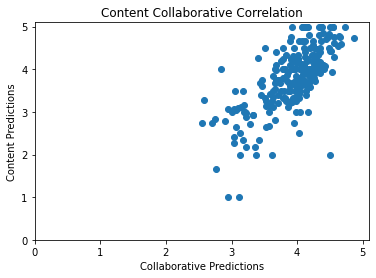

In [152]:
plt.ylim([0,5.1])
plt.xlim([0,5.1])
plt.scatter(hybrid["pred_rating_x"], hybrid["pred_rating_y"])
plt.title("Content Collaborative Correlation")
plt.xlabel("Collaborative Predictions")
plt.ylabel("Content Predictions")

In [131]:
hybrid["rating_actual"] = hybrid[["rating_x", "rating_y"]].mean(axis=1)
hybrid["rating_pred"] = hybrid[["pred_rating_x", "pred_rating_y"]].mean(axis=1)
hybrid = hybrid.drop(["rating_x", "rating_y", "pred_rating_x", "pred_rating_y"], axis=1)
hybrid

,uid,iid,rating_actual,rating_pred
0,58zhqwfGYEl92MZusTsYJg,SZU9c8V2GuREDN5KgyHFJw,3.5,4.384053
1,4fTm8qhzNnSXYHugs-Jcrw,vUrTGX_7HxqeoQ_6QCVz6g,4.0,3.996487
2,hmGY34f5S0KS27zj8Rz7nA,ctHjyadbDQAtUFfkcAFEHw,1.5,4.703532
3,hGuuVj6eXy7Ats7W30GXqQ,GBTPC53ZrG1ZBY3DT8Mbcw,5.0,4.069609
4,79i68GqE7NY8eP2LVQWJBg,ARgidflSXPHj7uhK-Y7hwA,3.0,3.351010
...,...,...,...,...
236,zziWJMYwDjyVi7kJmgRUvg,LjXS6sgzY6-kX2WKPykx_A,3.0,4.074900
237,yTYd4z4MjwOZVQpw71aT0Q,ZYRul0i1bhOjirHED6Kd0w,3.5,4.019794
238,7F_TQTRhsw-_uPAWLreT5A,L5uxkYPKhTl2YzL0rkpN6Q,5.0,3.890991
239,33uE6gRoelXAQCw9onVO0g,ZaW1E3Eeic8P0ZIOITBY7w,3.5,3.135561


In [132]:
mse, mae, r2 = mean_squared_error(hybrid.rating_actual, hybrid.rating_pred), \
                mean_absolute_error(hybrid.rating_actual, hybrid.rating_pred), \
                r2_score(hybrid.rating_actual, hybrid.rating_pred)
print('MSE: {0:.4f}, MAE: {1:.4f}, R2: {2:.4f}'.format(mse, mae, r2))

MSE: 1.2775, MAE: 0.9157, R2: 0.2464


In [133]:
test_ranks = pd.Series(hybrid.rating_actual).rank()
pred_ranks = pd.Series(hybrid.rating_pred).rank()
stats.spearmanr(test_ranks, pred_ranks)

SpearmanrResult(correlation=0.45047261889576046, pvalue=1.90950387054769e-13)